In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from io import StringIO
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!wget https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv

--2025-09-26 18:26:17--  https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1819904 (1.7M) [text/plain]
Saving to: ‘time_series_covid19_confirmed_global.csv’

time_series_covid19 100%[===================>]   1.74M  --.-KB/s    in 0.01s   

2025-09-26 18:26:17 (158 MB/s) - ‘time_series_covid19_confirmed_global.csv’ saved [1819904/1819904]



In [ ]:
def load_and_prepare_data(data_file, country='Afghanistan'):
    """Load and prepare time series data for a specific country"""
    df = pd.read_csv(data_file)

    # Filter for specific country
    country_data = df[df['Country/Region'] == country].iloc[0]

    # Extract date columns (skip first 4 columns: Province/State, Country/Region, Lat, Long)
    date_cols = df.columns[4:]
    cases = country_data[4:].values.astype(int)

    # Create time series dataframe
    ts_df = pd.DataFrame({
        'date': pd.to_datetime(date_cols, format='%m/%d/%y'),
        'cases': cases
    })
    ts_df.set_index('date', inplace=True)
    ts_df.sort_index(inplace=True)

    return ts_df

def prepare_lstm_data(data, lookback=7):
    """Prepare data for LSTM model"""
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data.values.reshape(-1, 1))

    X, y = [], []
    for i in range(lookback, len(scaled_data)):
        X.append(scaled_data[i-lookback:i, 0])
        y.append(scaled_data[i, 0])

    return np.array(X), np.array(y), scaler

def build_lstm_model(input_shape):
    """Build LSTM model"""
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        LSTM(50, return_sequences=False),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def train_arima_model(train_data):
    """Train ARIMA model"""
    # Simple ARIMA(1,1,1) model
    model = ARIMA(train_data, order=(2, 1, 2))
    fitted_model = model.fit()
    return fitted_model

def evaluate_model(actual, predicted, model_name):
    """Evaluate model performance"""
    mse = mean_squared_error(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mse)

    print(f"\n{model_name} Performance:")
    print(f"MSE: {mse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")

    return {'MSE': mse, 'MAE': mae, 'RMSE': rmse}

Loading and preparing data...
Data shape: (1143, 1)
Date range: 2020-01-22 00:00:00 to 2023-03-09 00:00:00
Train size: 914, Test size: 229

TRAINING ARIMA MODEL

TRAINING LSTM MODEL
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 

MODEL EVALUATION

ARIMA Performance:
MSE: 10908841222.87
MAE: 91912.98
RMSE: 104445.40

LSTM Performance:
MSE: 14134680495.52
MAE: 110133.44
RMSE: 118889.36


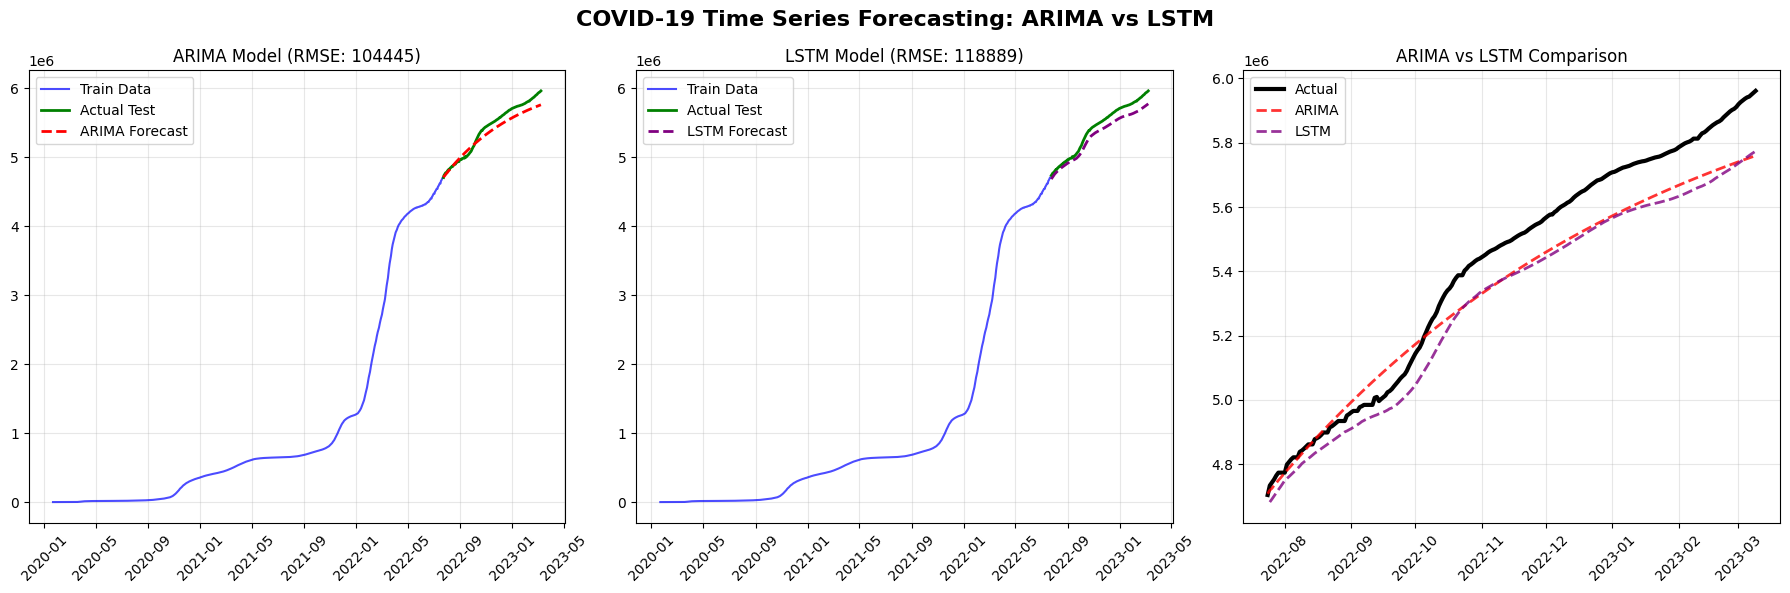


PERFORMANCE SUMMARY
   Model       RMSE        MAE           MSE
0  ARIMA  104445.40   91912.98  1.090884e+10
1   LSTM  118889.36  110133.44  1.413468e+10

Best performing model: ARIMA

MODEL CHARACTERISTICS

ARIMA Model:
- Statistical time series model
- Captures trends and seasonality
- Good for linear patterns
- Fast training and prediction

LSTM Model:
- Deep learning neural network
- Can capture complex non-linear patterns
- Uses sequence of past 7 days to predict next day
- Requires more data and computation

ANALYSIS COMPLETE


In [ ]:
# Load and prepare data
print("Loading and preparing data...")
ts_data = load_and_prepare_data('time_series_covid19_confirmed_global.csv', 'Austria')
print(f"Data shape: {ts_data.shape}")
print(f"Date range: {ts_data.index[0]} to {ts_data.index[-1]}")

# Split data into train and test (80-20 split)
train_size = int(len(ts_data) * 0.8)
train_data = ts_data[:train_size]
test_data = ts_data[train_size:]

print(f"Train size: {len(train_data)}, Test size: {len(test_data)}")

# 1. ARIMA Model
print("\n" + "="*50)
print("TRAINING ARIMA MODEL")
print("="*50)

arima_model = train_arima_model(train_data['cases'])
arima_forecast = arima_model.forecast(steps=len(test_data))
arima_fitted = arima_model.fittedvalues

# 2. LSTM Model
print("\n" + "="*50)
print("TRAINING LSTM MODEL")
print("="*50)

lookback = 7
X_lstm, y_lstm, lstm_scaler = prepare_lstm_data(ts_data['cases'], lookback)

# Split LSTM data
lstm_train_size = int(len(X_lstm) * 0.8)
X_train_lstm = X_lstm[:lstm_train_size]
y_train_lstm = y_lstm[:lstm_train_size]
X_test_lstm = X_lstm[lstm_train_size:]
y_test_lstm = y_lstm[lstm_train_size:]

# Build and train LSTM model
lstm_model = build_lstm_model((lookback, 1))
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=32, verbose=0)

# Make predictions
lstm_train_pred = lstm_model.predict(X_train_lstm)
lstm_test_pred = lstm_model.predict(X_test_lstm)

# Inverse transform predictions
lstm_train_pred = lstm_scaler.inverse_transform(lstm_train_pred)
lstm_test_pred = lstm_scaler.inverse_transform(lstm_test_pred)
y_train_lstm_actual = lstm_scaler.inverse_transform(y_train_lstm.reshape(-1, 1))
y_test_lstm_actual = lstm_scaler.inverse_transform(y_test_lstm.reshape(-1, 1))

# Model Evaluation
print("\n" + "="*50)
print("MODEL EVALUATION")
print("="*50)

arima_perf = evaluate_model(test_data['cases'], arima_forecast, "ARIMA")
lstm_perf = evaluate_model(y_test_lstm_actual.flatten(), lstm_test_pred.flatten(), "LSTM")

# Create comprehensive visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('COVID-19 Time Series Forecasting: ARIMA vs LSTM', fontsize=16, fontweight='bold')

# LSTM date alignment
lstm_train_dates = ts_data.index[lookback:lookback+len(lstm_train_pred)]
lstm_test_dates = ts_data.index[lookback+lstm_train_size:lookback+len(X_lstm)]

# Plot 1: ARIMA Model
axes[0].plot(train_data.index, train_data['cases'], label='Train Data', color='blue', alpha=0.7)
axes[0].plot(test_data.index, test_data['cases'], label='Actual Test', color='green', linewidth=2)
axes[0].plot(test_data.index, arima_forecast, label='ARIMA Forecast', color='red', linestyle='--', linewidth=2)
axes[0].set_title(f'ARIMA Model (RMSE: {arima_perf["RMSE"]:.0f})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Plot 2: LSTM Model
axes[1].plot(train_data.index, train_data['cases'], label='Train Data', color='blue', alpha=0.7)
axes[1].plot(lstm_test_dates, y_test_lstm_actual, label='Actual Test', color='green', linewidth=2)
axes[1].plot(lstm_test_dates, lstm_test_pred, label='LSTM Forecast', color='purple', linestyle='--', linewidth=2)
axes[1].set_title(f'LSTM Model (RMSE: {lstm_perf["RMSE"]:.0f})')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

# Plot 3: Direct Comparison
axes[2].plot(test_data.index, test_data['cases'], label='Actual', color='black', linewidth=3)
axes[2].plot(test_data.index, arima_forecast, label='ARIMA', color='red', linestyle='--', linewidth=2, alpha=0.8)
axes[2].plot(lstm_test_dates, lstm_test_pred, label='LSTM', color='purple', linestyle='--', linewidth=2, alpha=0.8)
axes[2].set_title('ARIMA vs LSTM Comparison')
axes[2].legend()
axes[2].grid(True, alpha=0.3)
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Performance Summary
print("\n" + "="*50)
print("PERFORMANCE SUMMARY")
print("="*50)

performance_df = pd.DataFrame({
    'Model': ['ARIMA', 'LSTM'],
    'RMSE': [arima_perf['RMSE'], lstm_perf['RMSE']],
    'MAE': [arima_perf['MAE'], lstm_perf['MAE']],
    'MSE': [arima_perf['MSE'], lstm_perf['MSE']]
})

print(performance_df.round(2))

# Find best model
best_model_idx = performance_df['RMSE'].idxmin()
best_model = performance_df.iloc[best_model_idx]['Model']
print(f"\nBest performing model: {best_model}")

# Additional insights
print("\n" + "="*50)
print("MODEL CHARACTERISTICS")
print("="*50)

print("\nARIMA Model:")
print("- Statistical time series model")
print("- Captures trends and seasonality")
print("- Good for linear patterns")
print("- Fast training and prediction")

print("\nLSTM Model:")
print("- Deep learning neural network")
print("- Can capture complex non-linear patterns")
print("- Uses sequence of past 7 days to predict next day")
print("- Requires more data and computation")

print("\n" + "="*50)
print("ANALYSIS COMPLETE")
print("="*50)